This file contains code that plots results from ST, WT, etc. on combined figures.

# Imports

In [16]:
import csv, numpy as np, matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from obspy.geodetics import gps2dist_azimuth
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plots

In [17]:
# Directory
INPUT_TXT = '/Users/emmanuelzheng/Downloads/Synthetics/Seiobs/Combined_Results.txt'

# Toggles
plotStarOnly = False
plotLabels = False
plotSNROnly = False
plotSNROnly2 = True
snlg_SNR_threshold = 3.0
snlg_SNR_threshold_2 = 2.0


## Sn/Lg v. d-H

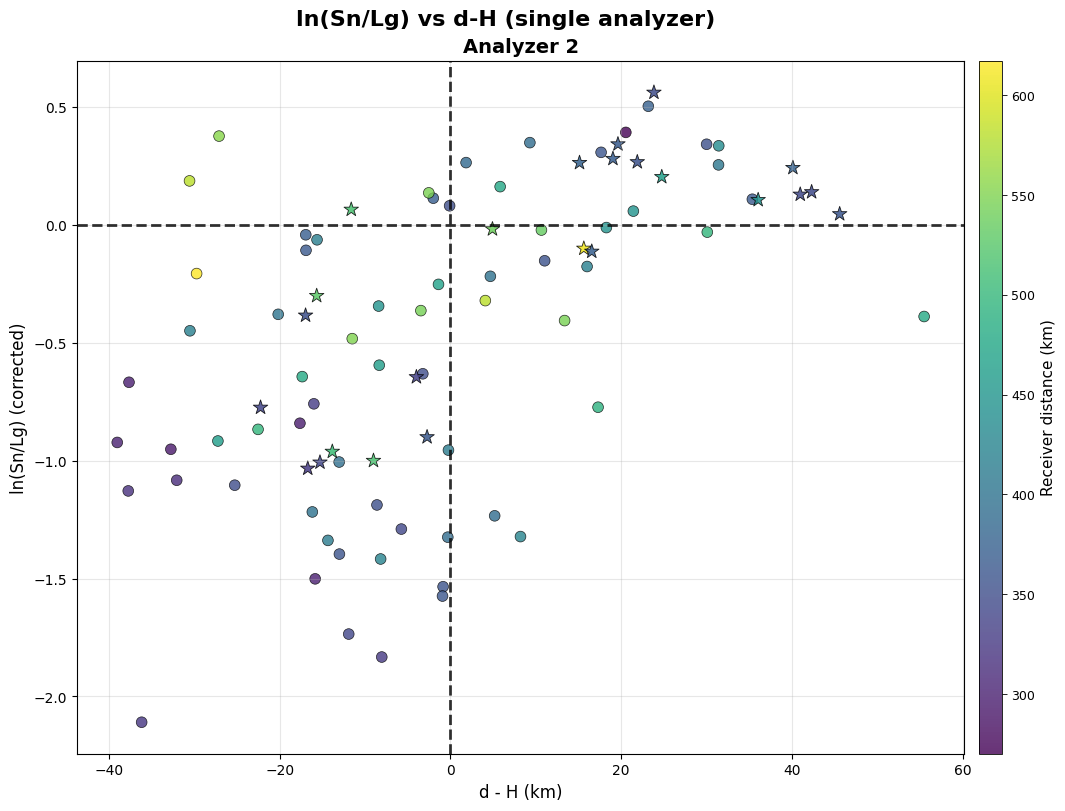

In [18]:
# Select analyzer to plot (1–4)
ANALYZER_INDEX = 2  # change to 2, 3, or 4 as needed

# Dashed guidelines per analyzer: (d_h_value, ln_snlg_value)
dashed_line_values = [
    (0, 0),  # Analyzer 1
    (0, 0),  # Analyzer 2
    (0, 0),  # Analyzer 3
    (0, 0),  # Analyzer 4
]

STATION_COORDS = {
    'LSA': (29.6573, 91.1042),
    'KBL': (34.53, 69.17),
}

rows = []
with open(INPUT_TXT, 'r') as f:
    rdr = csv.reader(f, delimiter='\t')
    for r in rdr:
        if r: rows.append(r)

# Collect values for all analyzers; we'll select one later
d_h_values = []
is_special = []

y1, y2, y3, y4 = [], [], [], []
snr1, snr2, snr3, snr4 = [], [], [], []  # used for masks only if requested

recv_dist_km_1, recv_dist_km_2, recv_dist_km_3, recv_dist_km_4 = [], [], [], []

for r in rows:
    evla = float(r[1]); evlo = float(r[2])

    d_h_values.append(float(r[6]) if r[6] != '' else np.nan)
    is_special.append(r[7] == '*')

    # Analyzer 1
    s1 = r[8]; st1 = 'LSA' if 'LSA' in s1 else 'KBL'
    dist_m, _, _ = gps2dist_azimuth(evla, evlo, STATION_COORDS[st1][0], STATION_COORDS[st1][1])
    recv_dist_km_1.append(dist_m / 1000.0)
    y1.append(float(r[9]) if r[9] != '' else np.nan)
    snr1.append(float(r[11]) if r[11] != '' else np.nan)

    # Analyzer 2
    s2 = r[14]; st2 = 'LSA' if 'LSA' in s2 else 'KBL'
    dist_m, _, _ = gps2dist_azimuth(evla, evlo, STATION_COORDS[st2][0], STATION_COORDS[st2][1])
    recv_dist_km_2.append(dist_m / 1000.0)
    y2.append(float(r[15]) if r[15] != '' else np.nan)
    snr2.append(float(r[17]) if r[17] != '' else np.nan)

    # Analyzer 3
    s3 = r[20]; st3 = 'LSA' if 'LSA' in s3 else 'KBL'
    dist_m, _, _ = gps2dist_azimuth(evla, evlo, STATION_COORDS[st3][0], STATION_COORDS[st3][1])
    recv_dist_km_3.append(dist_m / 1000.0)
    y3.append(float(r[21]) if r[21] != '' else np.nan)
    snr3.append(float(r[23]) if r[23] != '' else np.nan)

    # Analyzer 4
    s4 = r[26]; st4 = 'LSA' if 'LSA' in s4 else 'KBL'
    dist_m, _, _ = gps2dist_azimuth(evla, evlo, STATION_COORDS[st4][0], STATION_COORDS[st4][1])
    recv_dist_km_4.append(dist_m / 1000.0)
    y4.append(float(r[27]) if r[27] != '' else np.nan)
    snr4.append(float(r[29]) if r[29] != '' else np.nan)

# To numpy
d_h_values = np.array(d_h_values)
is_special = np.array(is_special, dtype=bool)

y1 = np.array(y1); y2 = np.array(y2); y3 = np.array(y3); y4 = np.array(y4)
snr1 = np.array(snr1); snr2 = np.array(snr2); snr3 = np.array(snr3); snr4 = np.array(snr4)

recv_dist_km_1 = np.array(recv_dist_km_1)
recv_dist_km_2 = np.array(recv_dist_km_2)
recv_dist_km_3 = np.array(recv_dist_km_3)
recv_dist_km_4 = np.array(recv_dist_km_4)

# Select analyzer
analyzers = {
    1: (y1, snr1, recv_dist_km_1, "Analyzer 1"),
    2: (y2, snr2, recv_dist_km_2, "Analyzer 2"),
    3: (y3, snr3, recv_dist_km_3, "Analyzer 3"),
    4: (y4, snr4, recv_dist_km_4, "Analyzer 4"),
}
y_data, snr_vals, recv_dist_km, title = analyzers[int(ANALYZER_INDEX)]
d_h_line, ln_snlg_line = dashed_line_values[int(ANALYZER_INDEX) - 1]

# Build masks
if plotSNROnly:
    snr_mask = snr_vals > snlg_SNR_threshold
elif plotSNROnly2:
    # If you have separate Sn/Lg SNRs, adapt here; otherwise use combined
    snr_mask = snr_vals > snlg_SNR_threshold_2
else:
    snr_mask = np.ones_like(y_data, dtype=bool)

valid_y = np.isfinite(y_data)
valid_x = np.isfinite(d_h_values)
valid_c = np.isfinite(recv_dist_km)
base_mask = is_special if plotStarOnly else np.ones_like(is_special, dtype=bool)

regular_base = np.zeros_like(is_special, dtype=bool) if plotStarOnly else ~is_special
special_base = is_special

# Figure and axis
fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)

# Color scale based on receiver distance (km)
mask_all = valid_x & valid_y & valid_c & snr_mask & base_mask
if np.any(mask_all):
    cmin = float(np.nanmin(recv_dist_km[mask_all]))
    cmax = float(np.nanmax(recv_dist_km[mask_all]))
    if not np.isfinite(cmin): cmin = 0.0
    if not np.isfinite(cmax) or cmax == cmin: cmax = cmin + 1e-6
else:
    cmin, cmax = 0.0, 1.0

scatter_for_cbar = None

# Regular points
regular_mask = regular_base & valid_x & valid_y & valid_c & snr_mask
if np.any(regular_mask):
    sc_reg = ax.scatter(
        d_h_values[regular_mask], y_data[regular_mask],
        c=recv_dist_km[regular_mask], cmap='viridis', vmin=cmin, vmax=cmax,
        marker='o', s=60, alpha=0.8, edgecolors='black', linewidth=0.5
    )
    if scatter_for_cbar is None: scatter_for_cbar = sc_reg
    if plotLabels:
        for idx in np.where(regular_mask)[0]:
            ax.annotate(f'{d_h_values[idx]:.2f}', (d_h_values[idx], y_data[idx]),
                        xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

# Special points
special_mask = special_base & valid_x & valid_y & valid_c & snr_mask
if np.any(special_mask):
    sc_spec = ax.scatter(
        d_h_values[special_mask], y_data[special_mask],
        c=recv_dist_km[special_mask], cmap='viridis', vmin=cmin, vmax=cmax,
        marker='*', s=120, alpha=0.85, edgecolors='black', linewidth=0.6
    )
    if scatter_for_cbar is None: scatter_for_cbar = sc_spec
    if plotLabels:
        for idx in np.where(special_mask)[0]:
            ax.annotate(f'{d_h_values[idx]:.2f}', (d_h_values[idx], y_data[idx]),
                        xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.9, weight='bold')

# Dashed guidelines
ax.axvline(x=d_h_line, color='black', linestyle='--', alpha=0.8, linewidth=2)
ax.axhline(y=ln_snlg_line, color='black', linestyle='--', alpha=0.8, linewidth=2)

# Labels and styling
ax.set_xlabel('d - H (km)', fontsize=12)
ax.set_ylabel('ln(Sn/Lg) (corrected)', fontsize=12)
ax.set_title(title, fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Slim, non-overlapping colorbar on the right for receiver distance
if scatter_for_cbar is not None:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2.5%", pad=0.15)
    cbar = fig.colorbar(scatter_for_cbar, cax=cax)
    cbar.set_label('Receiver distance (km)', fontsize=11)
    cbar.ax.tick_params(labelsize=9, width=0.6)
    cbar.outline.set_linewidth(0.6)

plt.suptitle('ln(Sn/Lg) vs d-H (single analyzer)', fontsize=16, fontweight='bold')
plt.show()

Total points plotted: 73
Total points plotted: 66
Total points plotted: 75
Total points plotted (agg SNR-weighted): 77


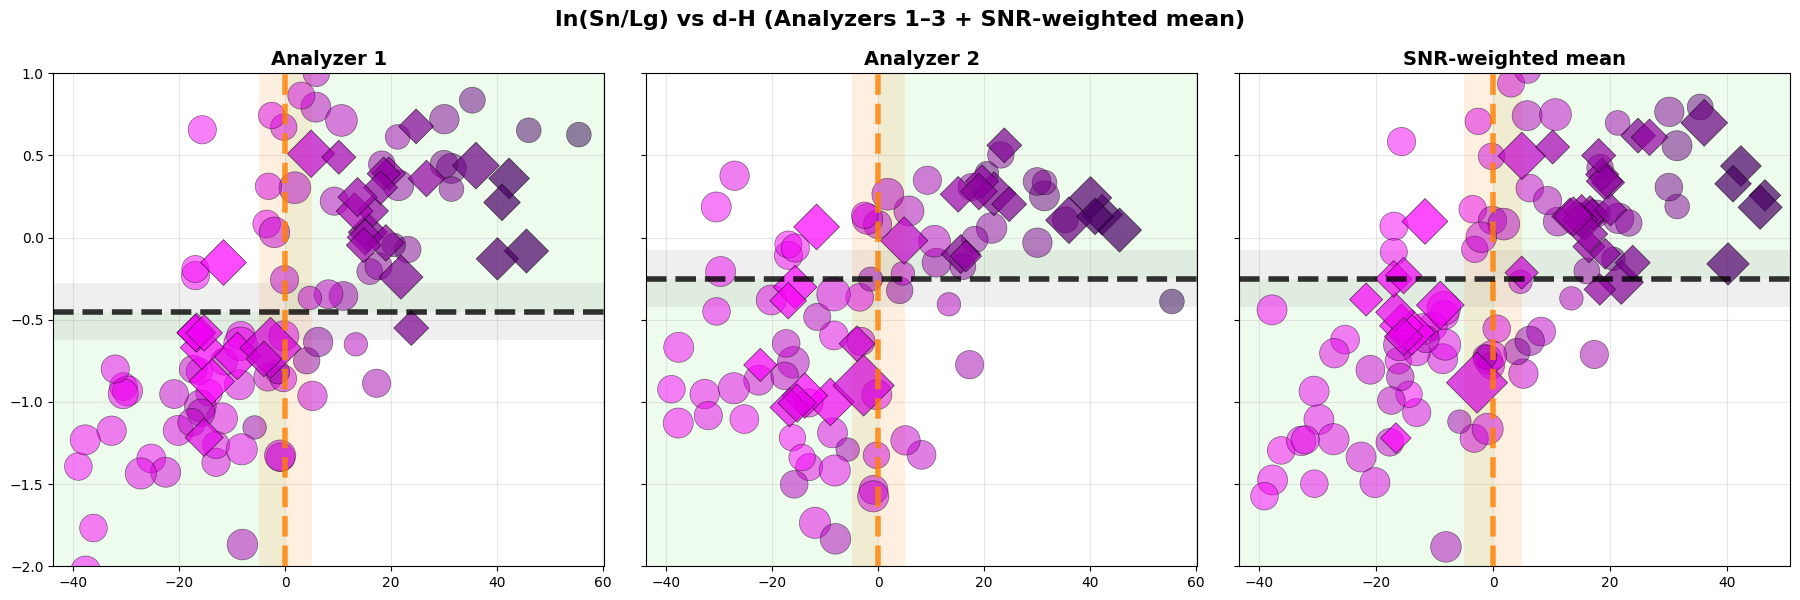

In [30]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap, Normalize

# If not already defined elsewhere, set the input file path
try:
    INPUT_TXT
except NameError:
    INPUT_TXT = '/Users/emmanuelzheng/Downloads/Synthetics/Seiobs/Combined_Results.txt'  # adjust if needed

# Column indices (0-based)
try:
    MAG_COL
except NameError:
    MAG_COL = 5  # adjust to correct magnitude column index
DEPTH_COL = 3   # color by depth in column index 3

# Toggle options and thresholds (override as needed)
plotSNROnly = False
plotSNROnly2 = True
plotStarOnly = False
plotLabels = True
snlg_SNR_threshold = 3.0
snlg_SNR_threshold_2 = 2.0

# Error band half-widths
MOHO_ERROR_BAND = 5.0      # +/- around vertical Moho bar
THRESH_ERROR_BAND = 0.175   # +/- around horizontal threshold bar

# Aggregated (4th panel) horizontal threshold for quadrant/guide
AGG_THRESHOLD_LINE = -0.30

# Y-axis zoom controls (use data quantiles to zoom while keeping 0 aligned)
Y_LO_Q = 0.11
Y_HI_Q = 0.95
Y_EXTRA_FRAC = 0.15  # extra padding beyond quantile range

# Dashed guidelines per analyzer: (d_h_value, ln_snlg_value)
# Move Analyzer 1 threshold down to -0.40
dashed_line_values = [
    (0, -0.45),  # Analyzer 1
    (0, -0.25),  # Analyzer 2
    (0, -0.25),  # Analyzer 3
    # (0, 0),      # Analyzer 4 (unused for per-analyzer panels)
]

# Read rows
rows = []
with open(INPUT_TXT, 'r') as f:
    rdr = csv.reader(f, delimiter='\t')
    for r in rdr:
        if r:
            rows.append(r)

# Collect values for analyzers 1–3
d_h_values = []
is_special = []

y1, y2, y3 = [], [], []
snr1, snr2, snr3 = [], [], []

# Event magnitudes (for size) and depths (for color)
event_mags = []
event_depths = []

for r in rows:
    d_h_values.append(float(r[6]) if r[6] != '' else np.nan)
    is_special.append(r[7] == '*')

    # Analyzer 1
    y1.append(float(r[9]) if r[9] != '' else np.nan)
    snr1.append(float(r[11]) if r[11] != '' else np.nan)

    # Analyzer 2
    y2.append(float(r[15]) if r[15] != '' else np.nan)
    snr2.append(float(r[17]) if r[17] != '' else np.nan)

    # Analyzer 3
    y3.append(float(r[21]) if r[21] != '' else np.nan)
    snr3.append(float(r[23]) if r[23] != '' else np.nan)

    # Magnitude (adjust MAG_COL if needed)
    try:
        event_mags.append(float(r[MAG_COL]) if r[MAG_COL] != '' else np.nan)
    except (IndexError, ValueError):
        event_mags.append(np.nan)

    # Depth (column index 3)
    try:
        event_depths.append(float(r[DEPTH_COL]) if r[DEPTH_COL] != '' else np.nan)
    except (IndexError, ValueError):
        event_depths.append(np.nan)

# To numpy
d_h_values = np.array(d_h_values)
is_special = np.array(is_special, dtype=bool)

y1 = np.array(y1); y2 = np.array(y2); y3 = np.array(y3)
snr1 = np.array(snr1); snr2 = np.array(snr2); snr3 = np.array(snr3)
event_mags = np.array(event_mags)
event_depths = np.array(event_depths)

# Prepare analyzers dictionary for 1–3
analyzers = {
    1: (y1, snr1, "Analyzer 1"),
    2: (y2, snr2, "Analyzer 2"),
    3: (y3, snr3, "Analyzer 3"),
}

# Base masks shared
valid_x = np.isfinite(d_h_values)
base_mask = is_special if plotStarOnly else np.ones_like(is_special, dtype=bool)
regular_base = np.zeros_like(is_special, dtype=bool) if plotStarOnly else ~is_special
special_base = is_special

# Magnitude-based sizes (fallback to 30.0 where mag is NaN)
mag_isfinite = np.isfinite(event_mags)
sizes_all = np.where(
    mag_isfinite,
    (np.maximum(event_mags, 0.0) ** 1.8) * 30.0,
    30.0
)

# Magenta → dark purple colormap
depth_cmap = LinearSegmentedColormap.from_list(
    'magenta_to_darkpurple', ['#ff00ff', '#2e004f']
)

# Normalize depths for color mapping
depth_isfinite = np.isfinite(event_depths)
if np.any(depth_isfinite):
    depth_min = float(np.nanmin(event_depths[depth_isfinite]))
    depth_max = float(np.nanmax(event_depths[depth_isfinite]))
else:
    depth_min, depth_max = 0.0, 1.0
depth_norm = Normalize(vmin=depth_min, vmax=depth_max)

# Compute a unified y-axis tick spacing across the subplots
def _snr_mask(vals):
    if plotSNROnly:
        return vals > snlg_SNR_threshold
    if plotSNROnly2:
        return vals > snlg_SNR_threshold_2
    return np.ones_like(vals, dtype=bool)

def _nice_step(ymin, ymax, target_ticks=6):
    rng = float(ymax - ymin) if np.isfinite(ymax - ymin) and (ymax > ymin) else 1.0
    raw = rng / max(target_ticks, 1)
    if raw == 0 or not np.isfinite(raw):
        return 0.1
    exp = int(np.floor(np.log10(raw)))
    scale = 10.0 ** exp
    norm = raw / scale
    bases = [1.0, 2.0, 2.5, 5.0, 10.0]
    base = next((b for b in bases if norm <= b), 10.0)
    return base * scale

# ----- Compute SNR-weighted mean across analyzers (4th panel data) -----
y_stack = np.vstack([y1, y2, y3])          # (3, N)
snr_stack = np.vstack([snr1, snr2, snr3])  # (3, N)
valid_y_stack = np.isfinite(y_stack)
snr2_pass_stack = snr_stack > snlg_SNR_threshold_2
use_mask_stack = valid_y_stack & snr2_pass_stack
weights = np.where(use_mask_stack, np.maximum(snr_stack, 0.0), 0.0)  # SNR^1 weighting
weighted_sum = np.nansum(weights * y_stack, axis=0)
weight_sum = np.nansum(weights, axis=0)
agg_wmean = np.divide(
    weighted_sum,
    weight_sum,
    out=np.full(y_stack.shape[1], np.nan, dtype=float),
    where=weight_sum > 0
)
agg_use_any = np.sum(use_mask_stack, axis=0) >= 1  # events with >=1 analyzer passing SNR2

# ----- Gather y across analyzers (+ aggregated) for zoomed limits -----
y_all = []
for idx in (1, 2, 3):
    y_data, snr_vals, _ = analyzers[idx]
    snr_mask_i = _snr_mask(snr_vals)
    valid_y_i = np.isfinite(y_data)
    mask_i = base_mask & valid_x & valid_y_i & snr_mask_i
    if np.any(mask_i):
        y_all.append(y_data[mask_i])

# Include aggregated SNR-weighted mean in axis scaling
agg_mask_for_axis = base_mask & valid_x & np.isfinite(agg_wmean) & agg_use_any
if np.any(agg_mask_for_axis):
    y_all.append(agg_wmean[agg_mask_for_axis])

if len(y_all):
    y_all = np.concatenate(y_all)
    # Quantile-based zoom
    y_lo = float(np.nanpercentile(y_all, Y_LO_Q * 100.0))
    y_hi = float(np.nanpercentile(y_all, Y_HI_Q * 100.0))
    span = y_hi - y_lo
    if not np.isfinite(span) or span <= 0:
        y_lo, y_hi, span = -1.0, 1.0, 2.0
    y_min_zoom = y_lo - span * Y_EXTRA_FRAC
    y_max_zoom = y_hi + span * Y_EXTRA_FRAC
    # Ensure 0 is included so it aligns across subplots
    y_min_zoom = min(y_min_zoom, 0.0)
    y_max_zoom = max(y_max_zoom, 0.0)
else:
    y_min_zoom, y_max_zoom = -1.0, 1.0

y_tick_step = _nice_step(y_min_zoom, y_max_zoom, target_ticks=6)

# Snap unified y-limits to the tick step so 0 aligns across subplots
if np.isfinite(y_tick_step) and y_tick_step > 0:
    y_floor = np.floor(y_min_zoom / y_tick_step) * y_tick_step
    y_ceil = np.ceil(y_max_zoom / y_tick_step) * y_tick_step
else:
    y_floor, y_ceil = y_min_zoom, y_max_zoom
if not np.isfinite(y_floor) or not np.isfinite(y_ceil) or y_floor == y_ceil:
    y_floor, y_ceil = -1.0, 1.0

# ----- Plot: 3 analyzers + SNR-weighted mean (side-by-side) -----
fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True, sharey=True)
fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.1, wspace=0.05, hspace=0.01)

# Analyzers 1–3
for idx, ax in enumerate(axes[:3], start=1):
    y_data, snr_vals, title = analyzers[idx]
    d_h_line, ln_snlg_line = dashed_line_values[idx - 1]

    # SNR mask
    if plotSNROnly:
        snr_mask = snr_vals > snlg_SNR_threshold
    elif plotSNROnly2:
        snr_mask = snr_vals > snlg_SNR_threshold_2
    else:
        snr_mask = np.ones_like(y_data, dtype=bool)

    valid_y = np.isfinite(y_data)

    # Regular points
    regular_mask = regular_base & valid_x & valid_y & snr_mask
    if np.any(regular_mask):
        ax.scatter(
            d_h_values[regular_mask], y_data[regular_mask],
            c=event_depths[regular_mask], cmap=depth_cmap, norm=depth_norm,
            s=sizes_all[regular_mask], marker='o', alpha=0.5,
            edgecolors='k', linewidths=0.5, zorder=2
        )

    # Special points
    special_mask = special_base & valid_x & valid_y & snr_mask
    if np.any(special_mask):
        ax.scatter(
            d_h_values[special_mask], y_data[special_mask],
            c=event_depths[special_mask], cmap=depth_cmap, norm=depth_norm,
            s=sizes_all[special_mask], marker='D', alpha=0.7,
            edgecolors='k', linewidths=0.5, zorder=3
        )
        # if plotLabels:
        #     for i_pt in np.where(special_mask)[0]:
        #         ax.annotate(f'{d_h_values[i_pt]:.2f}', (d_h_values[i_pt], y_data[i_pt]),
        #                     xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.9, weight='bold')

    # Apply unified y-limits so y=0 is aligned across subplots
    ax.set_ylim(y_floor, y_ceil)

    # Dashed guidelines
    ax.axvline(x=d_h_line, color='#ff8001', linestyle='--', alpha=0.8, linewidth=4, zorder=5)
    ax.axhline(y=ln_snlg_line, color='black', linestyle='--', alpha=0.8, linewidth=4, zorder=5)

    # Limits for patches
    x_min, x_max = ax.get_xlim()

    # Orange Moho error band (+/- MOHO_ERROR_BAND around vertical bar)
    rect_moho = Rectangle(
        (d_h_line - MOHO_ERROR_BAND, y_floor),
        width=MOHO_ERROR_BAND * 2.0,
        height=(y_ceil - y_floor),
        facecolor='#ff8001', edgecolor='none', alpha=0.12, zorder=1.6
    )
    ax.add_patch(rect_moho)

    # Threshold horizontal error band (+/- THRESH_ERROR_BAND around ln_snlg_line)
    rect_thresh = Rectangle(
        (x_min, ln_snlg_line - THRESH_ERROR_BAND),
        width=(x_max - x_min),
        height=THRESH_ERROR_BAND * 2.0,
        facecolor='gray', edgecolor='none', alpha=0.12, zorder=1.6
    )
    ax.add_patch(rect_thresh)

    # Shade lower-left quadrant
    if d_h_line > x_min and ln_snlg_line > y_floor:
        rect_ll = Rectangle(
            (x_min, y_floor),
            width=(d_h_line - x_min),
            height=(ln_snlg_line - y_floor),
            facecolor='lightgreen', edgecolor='none', alpha=0.15, zorder=1
        )
        ax.add_patch(rect_ll)

    # Shade top-right quadrant
    if d_h_line < x_max and ln_snlg_line < y_ceil:
        rect_tr = Rectangle(
            (d_h_line, ln_snlg_line),
            width=(x_max - d_h_line),
            height=(y_ceil - ln_snlg_line),
            facecolor='lightgreen', edgecolor='none', alpha=0.15, zorder=1
        )
        ax.add_patch(rect_tr)

    # Restore limits (ensure patches don't change autoscale)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_floor, y_ceil)

    # Labels and styling
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

    # Apply unified y-axis tick spacing
    ax.yaxis.set_major_locator(mticker.MultipleLocator(y_tick_step))

    # print total points plotted
    print(f"Total points plotted: {np.sum(regular_mask)}")

# # 4th panel: SNR-weighted mean across analyzers (SNR2 filter)
# ax = axes[3]
# d_h_line_agg = 0.0
# ln_snlg_line_agg = AGG_THRESHOLD_LINE

# valid_y_agg = np.isfinite(agg_wmean)
# regular_mask_agg = regular_base & valid_x & valid_y_agg & agg_use_any
# special_mask_agg = special_base & valid_x & valid_y_agg & agg_use_any

# if np.any(regular_mask_agg):
#     ax.scatter(
#         d_h_values[regular_mask_agg], agg_wmean[regular_mask_agg],
#         c=event_depths[regular_mask_agg], cmap=depth_cmap, norm=depth_norm,
#         s=sizes_all[regular_mask_agg], marker='o', alpha=0.5,
#         edgecolors='k', linewidths=0.5, zorder=2
#     )
# if np.any(special_mask_agg):
#     ax.scatter(
#         d_h_values[special_mask_agg], agg_wmean[special_mask_agg],
#         c=event_depths[special_mask_agg], cmap=depth_cmap, norm=depth_norm,
#         s=sizes_all[special_mask_agg], marker='D', alpha=0.7,
#         edgecolors='k', linewidths=0.5, zorder=3
#     )

# # Unified y-limits
# ax.set_ylim(y_floor, y_ceil)

# # Dashed guidelines for aggregated panel
# ax.axvline(x=d_h_line_agg, color='#ff8001', linestyle='--', alpha=0.8, linewidth=4, zorder=5)
# ax.axhline(y=ln_snlg_line_agg, color='black', linestyle='--', alpha=0.8, linewidth=4, zorder=5)

# # Limits for patches
# x_min, x_max = ax.get_xlim()

# # Orange Moho error band around vertical bar
# ax.add_patch(Rectangle(
#     (d_h_line_agg - MOHO_ERROR_BAND, y_floor),
#     width=MOHO_ERROR_BAND * 2.0,
#     height=(y_ceil - y_floor),
#     facecolor='#ff8001', edgecolor='none', alpha=0.12, zorder=1.6
# ))

# # Threshold horizontal error band
# ax.add_patch(Rectangle(
#     (x_min, ln_snlg_line_agg - THRESH_ERROR_BAND),
#     width=(x_max - x_min),
#     height=THRESH_ERROR_BAND * 2.0,
#     facecolor='gray', edgecolor='none', alpha=0.12, zorder=1.6
# ))

# # Quadrant shading
# if d_h_line_agg > x_min and ln_snlg_line_agg > y_floor:
#     ax.add_patch(Rectangle(
#         (x_min, y_floor),
#         width=(d_h_line_agg - x_min),
#         height=(ln_snlg_line_agg - y_floor),
#         facecolor='lightgreen', edgecolor='none', alpha=0.15, zorder=1
#     ))
# if d_h_line_agg < x_max and ln_snlg_line_agg < y_ceil:
#     ax.add_patch(Rectangle(
#         (d_h_line_agg, ln_snlg_line_agg),
#         width=(x_max - d_h_line_agg),
#         height=(y_ceil - ln_snlg_line_agg),
#         facecolor='lightgreen', edgecolor='none', alpha=0.15, zorder=1
#     ))

# Restore limits
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_floor, y_ceil)

# Labels and styling
ax.set_title('SNR-weighted mean', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_locator(mticker.MultipleLocator(y_tick_step))

print(f"Total points plotted (agg SNR-weighted): {np.sum(regular_mask_agg)}")

plt.suptitle('ln(Sn/Lg) vs d-H (Analyzers 1–3 + SNR-weighted mean)', fontsize=16, fontweight='bold')
plt.show()

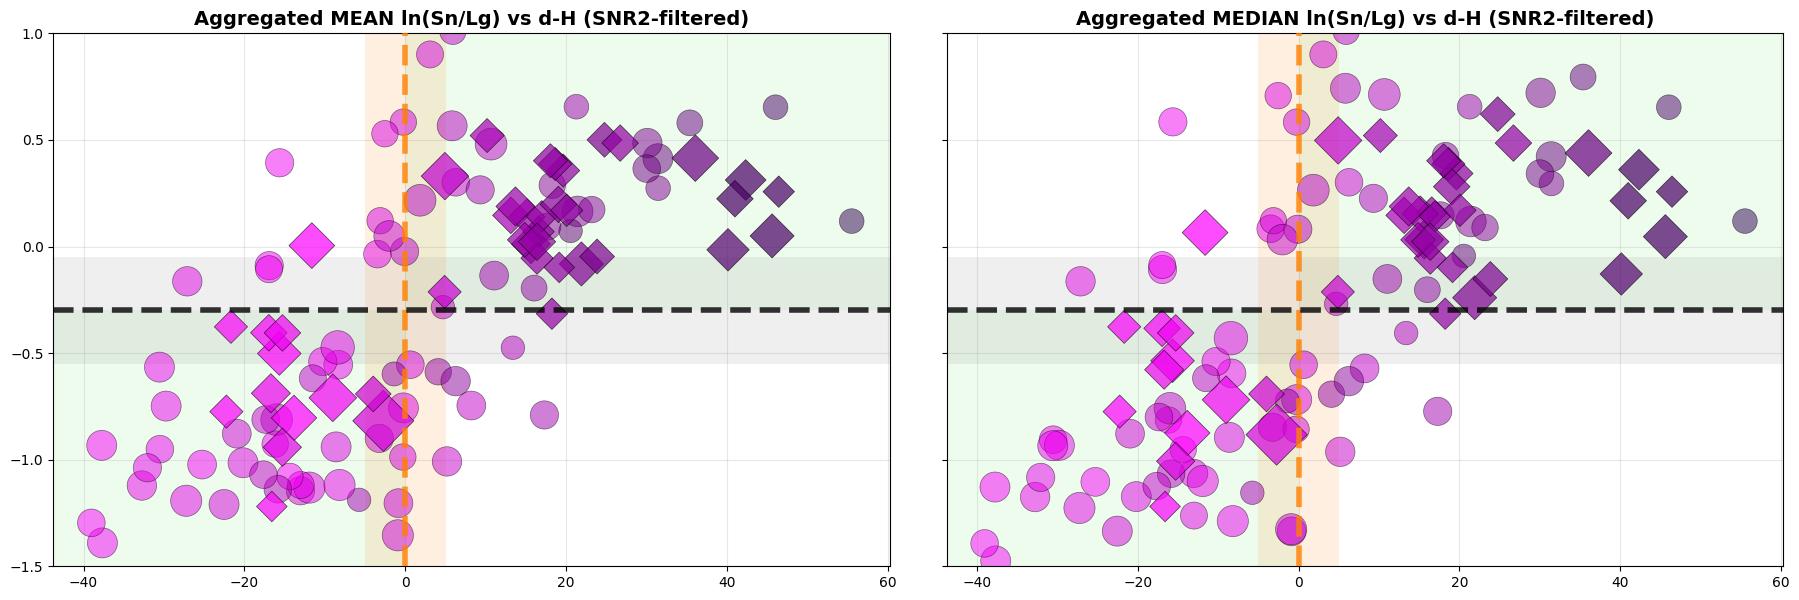

In [20]:
# Side-by-side aggregated plots: MEAN and MEDIAN across analyzers passing SNR2

AGG_THRESHOLD_LINE = -0.30  # horizontal threshold for aggregated plots

def compute_aggregated_stat(y_stack, snr_stack, snr_threshold, stat="mean"):
    """
    y_stack: (3, N) analyzer ln(Sn/Lg) values
    snr_stack: (3, N) analyzer SNR values
    Returns:
      agg_vals: (N,) aggregated values using only analyzers with SNR > threshold and finite y
      pass_counts: (N,) number of analyzers used per event
      use_mask: (3, N) boolean of analyzers used per event
    """
    valid_y = np.isfinite(y_stack)
    snr_pass = snr_stack > snr_threshold
    use_mask = valid_y & snr_pass
    pass_counts = np.sum(use_mask, axis=0)

    if stat == "mean":
        sum_vals = np.where(use_mask, y_stack, 0.0).sum(axis=0)
        agg_vals = np.divide(
            sum_vals,
            pass_counts,
            out=np.full(y_stack.shape[1], np.nan, dtype=float),
            where=pass_counts > 0
        )
    elif stat == "median":
        m = np.ma.masked_array(y_stack, mask=(~use_mask) | (~valid_y))
        agg_vals = np.ma.median(m, axis=0).filled(np.nan)
    else:
        raise ValueError("stat must be 'mean' or 'median'")

    return agg_vals, pass_counts, use_mask
    return agg_vals, pass_counts, use_mask

def plot_aggregated(ax, title, agg_vals, pass_counts, d_h_vals, is_special_mask,
                    sizes, depths, cmap, norm, y_floor, y_ceil,
                    vline_x=0.0, hline_y=AGG_THRESHOLD_LINE,
                    moho_band=MOHO_ERROR_BAND, thresh_band=THRESH_ERROR_BAND):
    valid_x = np.isfinite(d_h_vals)
    valid_y = np.isfinite(agg_vals)
    have_any = pass_counts >= 1
    base = np.ones_like(valid_x, dtype=bool) if not plotStarOnly else is_special_mask

    regular_mask = (~is_special_mask) & base & valid_x & valid_y & have_any
    special_mask = is_special_mask & base & valid_x & valid_y & have_any

    if np.any(regular_mask):
        ax.scatter(
            d_h_vals[regular_mask], agg_vals[regular_mask],
            c=depths[regular_mask], cmap=cmap, norm=norm,
            s=sizes[regular_mask], marker='o', alpha=0.5,
            edgecolors='k', linewidths=0.5, zorder=2
        )
    if np.any(special_mask):
        ax.scatter(
            d_h_vals[special_mask], agg_vals[special_mask],
            c=depths[special_mask], cmap=cmap, norm=norm,
            s=sizes[special_mask], marker='D', alpha=0.7,
            edgecolors='k', linewidths=0.5, zorder=3
        )

    ax.set_ylim(y_floor, y_ceil)

    # Dashed guideline bars
    ax.axvline(x=vline_x, color='#ff8001', linestyle='--', alpha=0.8, linewidth=4, zorder=5)
    ax.axhline(y=hline_y, color='black', linestyle='--', alpha=0.8, linewidth=4, zorder=5)

    # Limits for patches
    x_min, x_max = ax.get_xlim()

    # Orange Moho error band (+/- moho_band around vertical bar)
    ax.add_patch(Rectangle(
        (vline_x - moho_band, y_floor),
        width=moho_band * 2.0,
        height=(y_ceil - y_floor),
        facecolor='#ff8001', edgecolor='none', alpha=0.12, zorder=1.6
    ))

    # Threshold horizontal error band (+/- thresh_band around hline_y)
    ax.add_patch(Rectangle(
        (x_min, hline_y - thresh_band),
        width=(x_max - x_min),
        height=thresh_band * 2.0,
        facecolor='gray', edgecolor='none', alpha=0.12, zorder=1.6
    ))

    # Quadrant shading
    if vline_x > x_min and hline_y > y_floor:
        ax.add_patch(Rectangle(
            (x_min, y_floor),
            width=(vline_x - x_min),
            height=(hline_y - y_floor),
            facecolor='lightgreen', edgecolor='none', alpha=0.15, zorder=1
        ))
    if vline_x < x_max and hline_y < y_ceil:
        ax.add_patch(Rectangle(
            (vline_x, hline_y),
            width=(x_max - vline_x),
            height=(y_ceil - hline_y),
            facecolor='lightgreen', edgecolor='none', alpha=0.15, zorder=1
        ))

    # Restore limits in case patches changed autoscale
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_floor, y_ceil)

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)

# Stack analyzers for vectorized aggregation
y_stack = np.vstack([y1, y2, y3])          # shape (3, N)
snr_stack = np.vstack([snr1, snr2, snr3])  # shape (3, N)

# Compute mean and median with SNR2 filtering
agg_mean, pass_counts_mean, _ = compute_aggregated_stat(
    y_stack, snr_stack, snlg_SNR_threshold_2, stat="mean"
)
agg_median, pass_counts_median, _ = compute_aggregated_stat(
    y_stack, snr_stack, snlg_SNR_threshold_2, stat="median"
)

# Unified zoom and y-limits across both panels (keep 0 aligned)
vals_for_zoom = []
mask_mean_plot = (pass_counts_mean >= 1) & np.isfinite(agg_mean)
mask_median_plot = (pass_counts_median >= 1) & np.isfinite(agg_median)
if np.any(mask_mean_plot):
    vals_for_zoom.append(agg_mean[mask_mean_plot])
if np.any(mask_median_plot):
    vals_for_zoom.append(agg_median[mask_median_plot])

if len(vals_for_zoom):
    y_concat = np.concatenate(vals_for_zoom)
    y_lo = float(np.nanpercentile(y_concat, Y_LO_Q * 100.0))
    y_hi = float(np.nanpercentile(y_concat, Y_HI_Q * 100.0))
    span = y_hi - y_lo
    if not np.isfinite(span) or span <= 0:
        y_lo, y_hi, span = -1.0, 1.0, 2.0
    y_min_zoom = y_lo - span * Y_EXTRA_FRAC
    y_max_zoom = y_hi + span * Y_EXTRA_FRAC
    y_min_zoom = min(y_min_zoom, 0.0)
    y_max_zoom = max(y_max_zoom, 0.0)
else:
    y_min_zoom, y_max_zoom = -1.0, 1.0

y_step = _nice_step(y_min_zoom, y_max_zoom, target_ticks=6)
if np.isfinite(y_step) and y_step > 0:
    y_floor = np.floor(y_min_zoom / y_step) * y_step
    y_ceil = np.ceil(y_max_zoom / y_step) * y_step
else:
    y_floor, y_ceil = y_min_zoom, y_max_zoom
if not np.isfinite(y_floor) or not np.isfinite(y_ceil) or y_floor == y_ceil:
    y_floor, y_ceil = -1.0, 1.0

# Side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6), constrained_layout=True, sharey=True)
fig.set_constrained_layout_pads(w_pad=0.1, h_pad=0.1, wspace=0.05, hspace=0.01)

# Left: MEAN
plot_aggregated(
    ax=axes[0],
    title='Aggregated MEAN ln(Sn/Lg) vs d-H (SNR2-filtered)',
    agg_vals=agg_mean,
    pass_counts=pass_counts_mean,
    d_h_vals=d_h_values,
    is_special_mask=is_special,
    sizes=sizes_all,
    depths=event_depths,
    cmap=depth_cmap,
    norm=depth_norm,
    y_floor=y_floor,
    y_ceil=y_ceil,
    vline_x=0.0,
    hline_y=AGG_THRESHOLD_LINE,
    moho_band=MOHO_ERROR_BAND,
    thresh_band=THRESH_ERROR_BAND
)
axes[0].yaxis.set_major_locator(mticker.MultipleLocator(y_step))

# Right: MEDIAN
plot_aggregated(
    ax=axes[1],
    title='Aggregated MEDIAN ln(Sn/Lg) vs d-H (SNR2-filtered)',
    agg_vals=agg_median,
    pass_counts=pass_counts_median,
    d_h_vals=d_h_values,
    is_special_mask=is_special,
    sizes=sizes_all,
    depths=event_depths,
    cmap=depth_cmap,
    norm=depth_norm,
    y_floor=y_floor,
    y_ceil=y_ceil,
    vline_x=0.0,
    hline_y=AGG_THRESHOLD_LINE,
    moho_band=MOHO_ERROR_BAND,
    thresh_band=THRESH_ERROR_BAND
)
axes[1].yaxis.set_major_locator(mticker.MultipleLocator(y_step))

plt.show()

## d-H v. distance

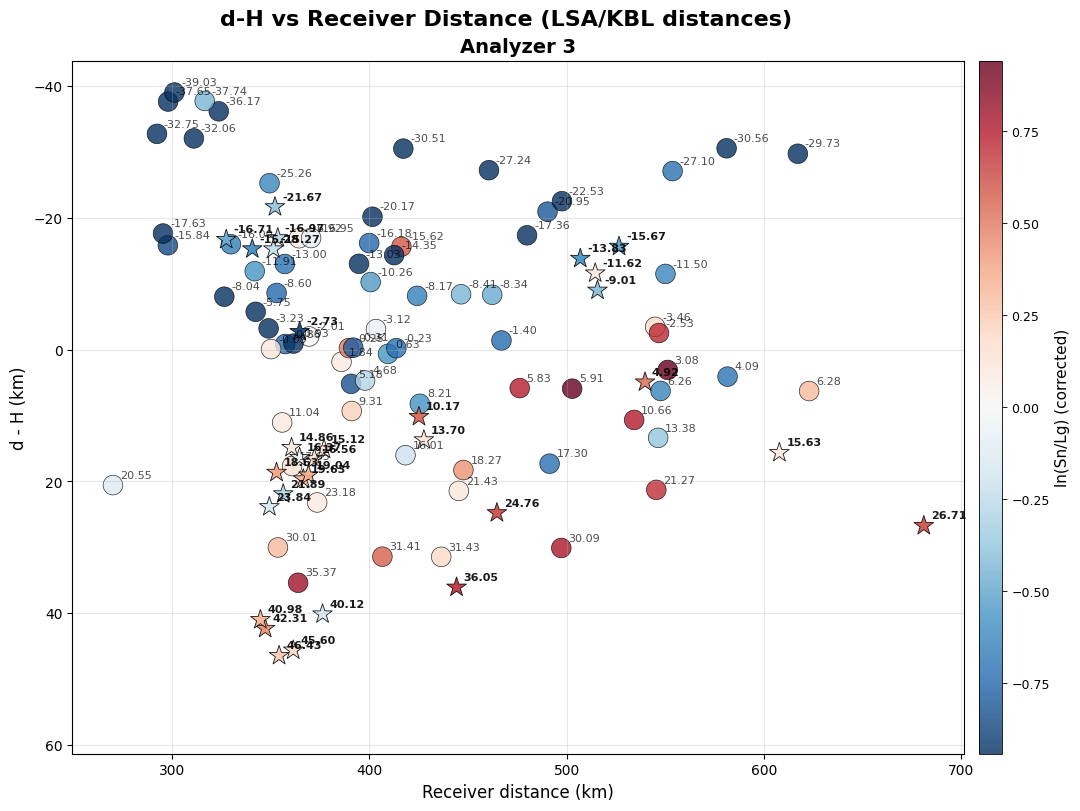

In [21]:
# Select analyzer to plot (1–4)
ANALYZER_INDEX = 3

STATION_COORDS = {
	'LSA': (29.6573, 91.1042),
	'KBL': (34.53, 69.17),
}

rows = []
with open(INPUT_TXT, 'r') as f:
	rdr = csv.reader(f, delimiter='\t')
	for r in rdr:
		if r: rows.append(r)

recv_dist_km_1, recv_dist_km_2, recv_dist_km_3, recv_dist_km_4 = [], [], [], []
d_h_all = []
is_star_all = []

y1, y2, y3, y4 = [], [], [], []
snr1, snr2, snr3, snr4 = [], [], [], []
snr1_sn, snr1_lg = [], []
snr2_sn, snr2_lg = [], []
snr3_sn, snr3_lg = [], []
snr4_sn, snr4_lg = [], []

for r in rows:
	evla = float(r[1]); evlo = float(r[2])
	d_h_all.append(float(r[6]) if r[6] != '' else np.nan)
	is_star_all.append(r[7] == '*')

	# Analyzer 1
	s1 = r[8]; st1 = 'LSA' if 'LSA' in s1 else 'KBL'
	dist_m, _, _ = gps2dist_azimuth(evla, evlo, STATION_COORDS[st1][0], STATION_COORDS[st1][1])
	recv_dist_km_1.append(dist_m / 1000.0)
	y1.append(float(r[9]) if r[9] != '' else np.nan)
	snr1.append(float(r[11]) if r[11] != '' else np.nan)
	snr1_sn.append(float(r[12]) if r[12] != '' else np.nan)
	snr1_lg.append(float(r[13]) if r[13] != '' else np.nan)

	# Analyzer 2
	s2 = r[14]; st2 = 'LSA' if 'LSA' in s2 else 'KBL'
	dist_m, _, _ = gps2dist_azimuth(evla, evlo, STATION_COORDS[st2][0], STATION_COORDS[st2][1])
	recv_dist_km_2.append(dist_m / 1000.0)
	y2.append(float(r[15]) if r[15] != '' else np.nan)
	snr2.append(float(r[17]) if r[17] != '' else np.nan)
	snr2_sn.append(float(r[18]) if r[18] != '' else np.nan)
	snr2_lg.append(float(r[19]) if r[19] != '' else np.nan)

	# Analyzer 3
	s3 = r[20]; st3 = 'LSA' if 'LSA' in s3 else 'KBL'
	dist_m, _, _ = gps2dist_azimuth(evla, evlo, STATION_COORDS[st3][0], STATION_COORDS[st3][1])
	recv_dist_km_3.append(dist_m / 1000.0)
	y3.append(float(r[21]) if r[21] != '' else np.nan)
	snr3.append(float(r[23]) if r[23] != '' else np.nan)
	snr3_sn.append(float(r[24]) if r[24] != '' else np.nan)
	snr3_lg.append(float(r[25]) if r[25] != '' else np.nan)

	# Analyzer 4
	s4 = r[26]; st4 = 'LSA' if 'LSA' in s4 else 'KBL'
	dist_m, _, _ = gps2dist_azimuth(evla, evlo, STATION_COORDS[st4][0], STATION_COORDS[st4][1])
	recv_dist_km_4.append(dist_m / 1000.0)
	y4.append(float(r[27]) if r[27] != '' else np.nan)
	snr4.append(float(r[29]) if r[29] != '' else np.nan)
	snr4_sn.append(float(r[30]) if r[30] != '' else np.nan)
	snr4_lg.append(float(r[31]) if r[31] != '' else np.nan)

recv_dist_km_1 = np.array(recv_dist_km_1)
recv_dist_km_2 = np.array(recv_dist_km_2)
recv_dist_km_3 = np.array(recv_dist_km_3)
recv_dist_km_4 = np.array(recv_dist_km_4)
d_h_all = np.array(d_h_all)
is_star_all = np.array(is_star_all, dtype=bool)

y1 = np.array(y1); y2 = np.array(y2); y3 = np.array(y3); y4 = np.array(y4)
snr1 = np.array(snr1); snr2 = np.array(snr2); snr3 = np.array(snr3); snr4 = np.array(snr4)
snr1_sn = np.array(snr1_sn); snr1_lg = np.array(snr1_lg)
snr2_sn = np.array(snr2_sn); snr2_lg = np.array(snr2_lg)
snr3_sn = np.array(snr3_sn); snr3_lg = np.array(snr3_lg)
snr4_sn = np.array(snr4_sn); snr4_lg = np.array(snr4_lg)

analyzers = {
	1: (recv_dist_km_1, y1, "Analyzer 1", snr1, snr1_sn, snr1_lg),
	2: (recv_dist_km_2, y2, "Analyzer 2", snr2, snr2_sn, snr2_lg),
	3: (recv_dist_km_3, y3, "Analyzer 3", snr3, snr3_sn, snr3_lg),
	4: (recv_dist_km_4, y4, "Analyzer 4", snr4, snr4_sn, snr4_lg),
}
xvals, yvals, title, snr_vals, snr_sn_vals, snr_lg_vals = analyzers[int(ANALYZER_INDEX)]

cmap_name = 'RdBu_r'
fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)

neutral_value = 0.0
saturation_factor = 0.5

base_mask_common = is_star_all if plotStarOnly else np.ones_like(is_star_all, dtype=bool)
if plotSNROnly:
	snr_mask = snr_vals > snlg_SNR_threshold
elif plotSNROnly2:
	snr_mask = (snr_sn_vals > snlg_SNR_threshold_2) & (snr_lg_vals > snlg_SNR_threshold_2)
else:
	snr_mask = np.ones_like(yvals, dtype=bool)

valid_y = np.isfinite(yvals)
global_mask = base_mask_common & valid_y & snr_mask

if np.any(global_mask):
	valid_vals = yvals[global_mask]
	max_dev = float(max(abs(np.nanmax(valid_vals) - neutral_value),
						abs(np.nanmin(valid_vals) - neutral_value)))
	if not np.isfinite(max_dev) or max_dev == 0:
		max_dev = 1e-6
else:
	max_dev = 1e-6

vmin_plot = neutral_value - (max_dev * saturation_factor)
vmax_plot = neutral_value + (max_dev * saturation_factor)

if d_h_all.size:
	ymin, ymax = float(np.nanmin(d_h_all)), float(np.nanmax(d_h_all))
	pad = 0.05 * max(ymax - ymin, 1e-6)
	y_lower, y_upper = ymax + pad, ymin - pad

if plotStarOnly:
	regular_base = np.zeros_like(is_star_all, dtype=bool)
	special_base = is_star_all
else:
	regular_base = ~is_star_all
	special_base = is_star_all

scatter_for_cbar = None

regular_mask = regular_base & valid_y & snr_mask
if np.any(regular_mask):
	sc_reg = ax.scatter(
		xvals[regular_mask], d_h_all[regular_mask],
		c=yvals[regular_mask], cmap=cmap_name, vmin=vmin_plot, vmax=vmax_plot,
		marker='o', s=200, alpha=0.8, edgecolors='black', linewidth=0.5
	)
	if scatter_for_cbar is None: scatter_for_cbar = sc_reg
	if plotLabels:
		for idx in np.where(regular_mask)[0]:
			ax.annotate(f'{d_h_all[idx]:.2f}', (xvals[idx], d_h_all[idx]),
						xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

special_mask = special_base & valid_y & snr_mask
if np.any(special_mask):
	sc_spec = ax.scatter(
		xvals[special_mask], d_h_all[special_mask],
		c=yvals[special_mask], cmap=cmap_name, vmin=vmin_plot, vmax=vmax_plot,
		marker='*', s=220, alpha=0.9, edgecolors='black', linewidth=0.6
	)
	if scatter_for_cbar is None: scatter_for_cbar = sc_spec
	if plotLabels:
		for idx in np.where(special_mask)[0]:
			ax.annotate(f'{d_h_all[idx]:.2f}', (xvals[idx], d_h_all[idx]),
						xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.9, weight='bold')

ax.set_xlabel('Receiver distance (km)', fontsize=12)
ax.set_ylabel('d - H (km)', fontsize=12)
ax.set_title(title, fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

if d_h_all.size:
	ax.set_ylim(y_lower, y_upper)
	ax.yaxis.set_major_locator(MaxNLocator(nbins=6))
	ax.tick_params(axis='y', which='both', labelleft=True)

# Append a slim colorbar axis to the right of the plot (no overlap)
if scatter_for_cbar is not None:
	divider = make_axes_locatable(ax)
	cax = divider.append_axes("right", size="2.5%", pad=0.15)  # smaller width and clear padding
	cbar = fig.colorbar(scatter_for_cbar, cax=cax)
	cbar.set_label('ln(Sn/Lg) (corrected)', fontsize=11)
	cbar.ax.tick_params(labelsize=9, width=0.6)
	cbar.outline.set_linewidth(0.6)

plt.suptitle('d-H vs Receiver Distance (LSA/KBL distances)', fontsize=16, fontweight='bold')
plt.show()